In [1]:
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid", {
 'axes.spines.bottom': True,
 'axes.spines.left': True,
 'axes.spines.right': True,
 'axes.spines.top': True
})
sns.set(font_scale=1)
sns.set_style("whitegrid")
#sns.set_style("darkgrid")
#sns.set_context("poster")
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
%matplotlib inline
import sys
import os
from scipy.optimize import newton, minimize, fsolve
import numpy as np
import copy
import re

import matplotlib.colors as mcolors
palette = list(mcolors.TABLEAU_COLORS.keys())
palette.extend(['salmon', 'teal','yellowgreen'])

import random

In [2]:
sns.set_theme(style="ticks", palette="muted")
#sns.set_context("talk")

In [3]:
palette = sns.color_palette(as_cmap=True)

In [4]:
AA_keys = ['Alanine pos', 'Arginine pos', 'Aspartate neg', 'Glutamate neg', 'Glycine pos', 'Isoleucine pos', 'Leucine pos', 'Lysine pos', 'Methionine pos', 'Phenylalanine pos', 'Proline pos', 'Serine neg', 'Threonine neg', 'Tyrosine pos', 'Valine pos']


GAUCT_keys = ['Guanine pos', 'Adenine pos', 'Uracil neg', 'Cytosine pos', 'Hypoxanthine pos']
pool14_keys = ['Adenosine pos', 'Deoxythymidine neg', 'Deoxycytidine pos', 'Deoxyuridine neg', 'Cytidine pos', 'Guanosine pos', 'Uridine pos']
cell_keys = ['Adenosine pos', 'Deoxythymidine neg', 'Deoxycytidine pos', 'Cytidine pos', 'Guanosine pos', 'Uridine neg']
nucl_breakdown_keys = GAUCT_keys + ['Uric acid neg', 'Xanthine neg', 'Glycine pos']

In [5]:
### Read measurements

annotation_df = pd.read_excel('annotations.xlsx')

### Replace all N/F with 0 before start ###
esheet_dict_mes = pd.read_excel('nucleotide_acid-hydrolysis_time-opti.xlsx', sheet_name=None)

metab_dict_mes = dict()
metab_names_mes = list()
for k in esheet_dict_mes.keys():
    if 'U-13C' not in k:
        metab_names_mes.append(k)
        metab_dict_mes[k] = copy.deepcopy(esheet_dict_mes[k]).rename(columns={'Area': 'Response'}).fillna(0)
        # If internal standard use response ratio:
        ### Turned on
        if sum(metab_dict_mes[k]['Response Ratio']) != 0 and True:
            metab_dict_mes[k]['Response'] = metab_dict_mes[k]['Response Ratio']
        metab_dict_mes[k]['Sample_name'] = metab_dict_mes[k]['Sample ID']
        
        # Add annotations:
        metab_dict_mes[k] = metab_dict_mes[k].merge(annotation_df, left_on='Sample_name', right_on='Sample_name')
        metab_dict_mes[k] = metab_dict_mes[k].drop(['Type', 'Filename', 'Response Ratio', 'Sample ID', 'Flag Details'], axis=1)


df = copy.deepcopy(metab_dict_mes[metab_names_mes[0]]).drop(['Compound', 'RT', 'Formula', 'Response'], axis=1)
for nam in metab_names_mes:
    assert(metab_dict_mes[nam]['Sample_name'].equals(df['Sample_name']))
    df[nam] = metab_dict_mes[nam]['Response']

In [6]:
df

,Sample_name,Replicate,Content,Hydrolysis time,Unnamed: 4,Adenine pos,Adenosine pos,Alanine pos,Arginine pos,Aspartate neg,...,Serine neg,Threonine neg,Thymine neg,Tryptophan pos,Tyrosine pos,Uracil neg,Uric acid neg,Uridine neg,Valine pos,Xanthine neg
0,AH01,1,Cells,0,AH1,0.007,0.019,0.414,0.793,13.397,...,0.074,6.589,0.020,2.509,2.533,0.000,2.680,0.006,1.352,0.075
1,AH02,2,Cells,0,AH2,0.007,0.019,0.424,0.800,13.986,...,0.077,6.681,0.028,2.488,2.546,0.003,2.623,0.010,1.346,0.073
2,AH03,1,Cells,1,AH3,27.142,0.000,1.681,7.142,16.852,...,10.413,9.689,11.500,2.606,5.998,0.269,2.497,1.443,1.740,0.595
3,AH04,2,Cells,1,AH4,28.472,0.000,1.835,7.926,18.104,...,11.414,10.246,12.211,2.573,6.192,0.330,2.576,1.725,1.843,0.681
4,AH05,1,Cells,2,AH5,26.143,0.000,3.863,19.543,21.869,...,26.435,15.110,17.355,1.027,13.947,0.797,2.617,4.843,3.276,1.617
5,AH06,2,Cells,2,AH6,29.991,0.000,4.009,19.604,22.920,...,25.878,15.772,18.704,1.108,13.686,0.844,2.634,5.255,3.302,1.654
6,AH07,1,Cells,4,AH7,27.307,0.000,7.437,44.575,32.082,...,55.546,29.477,22.090,0.086,33.983,2.112,2.527,12.369,7.626,4.178
7,AH08,2,Cells,4,AH8,27.577,0.000,5.167,27.227,25.247,...,37.950,19.385,18.901,0.133,21.861,0.975,2.812,7.345,4.540,2.165
8,AH09,1,Cells,6,AH9,26.937,0.000,7.507,43.269,31.235,...,53.413,28.914,20.875,0.049,36.081,2.212,1.912,14.036,7.591,3.803
9,AH10,2,Cells,6,AH10,27.052,0.000,7.779,45.989,32.449,...,52.430,30.753,20.229,0.042,41.229,2.224,2.174,13.330,8.176,4.013


In [17]:
### Show degradation of nucleosides after acid incubation of whole cell extract ###
df_AA = df

metab_mask = ['Hydrolysis time'] + cell_keys
df_metab = df_AA.loc[:, metab_mask]

metab_mask = ['Hydrolysis time']
for metab in cell_keys:
    mask_norm = df_metab['Hydrolysis time'] == 0
    metab_name = metab[0:-4]
    metab_norm_mean = df_metab.loc[mask_norm, metab].mean()
    df_metab[metab_name] = df_metab[metab] / metab_norm_mean
    metab_mask.append(metab_name)

df_metab = df_metab.loc[:, metab_mask]

df_metab_flat = pd.melt(df_metab, id_vars=['Hydrolysis time']).rename(columns={'variable': 'Nucleoside', 'value': 'Peak area'})

<Figure size 432x288 with 0 Axes>

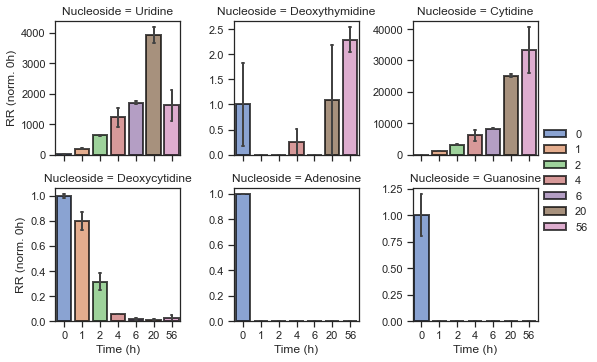

In [18]:
plot_name = 'whole-cell-time_nucleoside-stability.pdf'
pdf_plot = matplotlib.backends.backend_pdf.PdfPages(plot_name)

fig = plt.figure()
col_order = ['Uridine', 'Deoxythymidine', 'Cytidine', 'Deoxycytidine', 'Adenosine', 'Guanosine']
sns_fig = sns.FacetGrid(df_metab_flat, col='Nucleoside', height=2.5, col_wrap=3, despine=False, sharey=False, col_order=col_order)
sns_fig.map_dataframe(sns.barplot, x='Hydrolysis time', y='Peak area', ci=90, hue='Hydrolysis time', capsize=.1, errwidth=2, dodge=False, edgecolor='black', linewidth=2, alpha=0.7, palette=palette)
sns_fig.set_axis_labels('Time (h)', 'RR (norm. 0h)')
sns_fig.add_legend()


pdf_plot.savefig(sns_fig.fig, bbox_inches='tight')
plt.show()
pdf_plot.close()

In [19]:
### Show appearance of nucleobases after acid incubation of whole cell extract ###
df_AA = df

metab_mask = ['Hydrolysis time'] + nucl_breakdown_keys
df_metab = df_AA.loc[:, metab_mask]

metab_mask = ['Hydrolysis time']
for metab in nucl_breakdown_keys:
    mask_norm = df_metab['Hydrolysis time'] == 56
    metab_name = metab[0:-4]
    metab_norm_mean = df_metab.loc[mask_norm, metab].mean()
    df_metab[metab_name] = df_metab[metab] / metab_norm_mean
    metab_mask.append(metab_name)

df_metab = df_metab.loc[:, metab_mask]

df_metab_flat = pd.melt(df_metab, id_vars=['Hydrolysis time']).rename(columns={'variable': 'Nucleobase', 'value': 'Peak area'})

<Figure size 432x288 with 0 Axes>

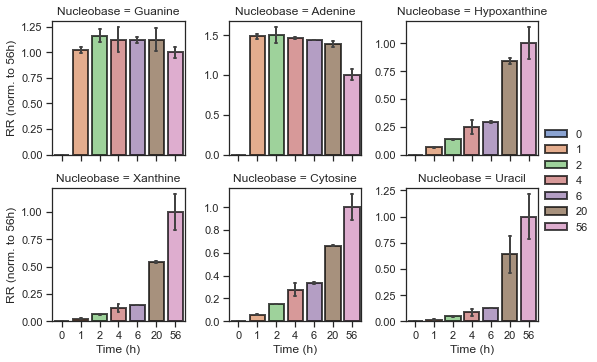

In [22]:
plot_name = 'whole-cell-time_nucleobase-release.pdf'
pdf_plot = matplotlib.backends.backend_pdf.PdfPages(plot_name)

fig = plt.figure()
col_order = ['Guanine', 'Adenine', 'Hypoxanthine', 'Xanthine', 'Cytosine', 'Uracil']
sns_fig = sns.FacetGrid(df_metab_flat, col='Nucleobase', height=2.5, col_wrap=3, despine=False, sharey=False, col_order=col_order)
sns_fig.map_dataframe(sns.barplot, x='Hydrolysis time', y='Peak area', ci=90, hue='Hydrolysis time', capsize=.1, errwidth=2, dodge=False, edgecolor='black', linewidth=2, alpha=0.7, palette=palette)
sns_fig.set_axis_labels('Time (h)', 'RR (norm. to 56h)')
sns_fig.add_legend()


pdf_plot.savefig(sns_fig.fig, bbox_inches='tight')
plt.show()
pdf_plot.close()

In [23]:
### Show appearance of nucleobases after acid incubation of whole cell extract ###
df_AA = df

metab_mask = ['Hydrolysis time'] + AA_keys
df_metab = df_AA.loc[:, metab_mask]

metab_mask = ['Hydrolysis time']
for metab in AA_keys:
    mask_norm = df_metab['Hydrolysis time'] == 56
    metab_name = metab[0:-4]
    metab_norm_mean = df_metab.loc[mask_norm, metab].mean()
    df_metab[metab_name] = df_metab[metab] / metab_norm_mean
    metab_mask.append(metab_name)

df_metab = df_metab.loc[:, metab_mask]

df_metab_flat = pd.melt(df_metab, id_vars=['Hydrolysis time']).rename(columns={'variable': 'Amino acid', 'value': 'Peak area'})

<Figure size 432x288 with 0 Axes>

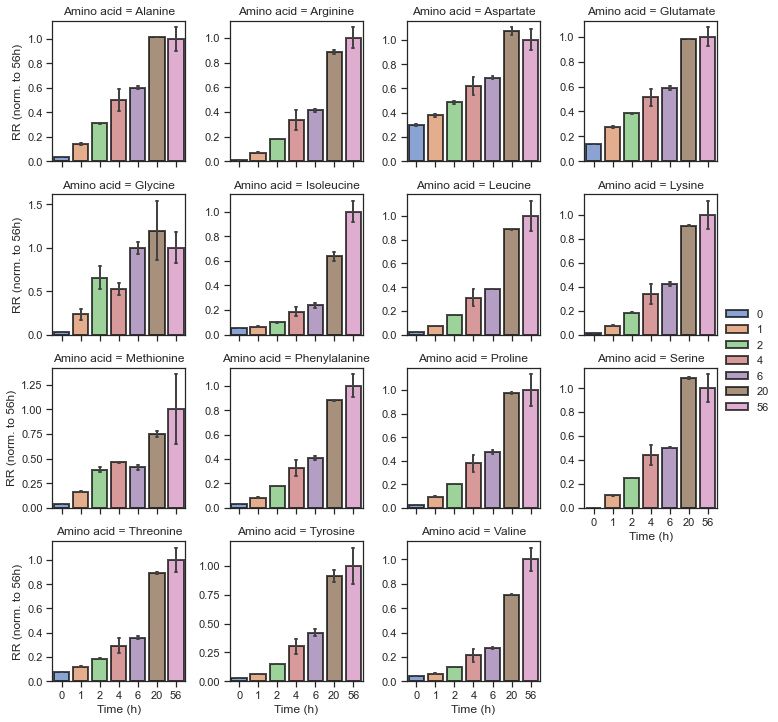

In [24]:
plot_name = 'whole-cell-time_amino-acid-release.pdf'
pdf_plot = matplotlib.backends.backend_pdf.PdfPages(plot_name)

fig = plt.figure()

sns_fig = sns.FacetGrid(df_metab_flat, col='Amino acid', height=2.5, col_wrap=4, despine=False, sharey=False)
sns_fig.map_dataframe(sns.barplot, x='Hydrolysis time', y='Peak area', ci=90, hue='Hydrolysis time', capsize=.1, errwidth=2, dodge=False, edgecolor='black', linewidth=2, alpha=0.7, palette=palette)
sns_fig.set_axis_labels('Time (h)', 'RR (norm. to 56h)')
sns_fig.add_legend()


pdf_plot.savefig(sns_fig.fig, bbox_inches='tight')
plt.show()
pdf_plot.close()